In [118]:
# Initialize Otter
import otter
grader = otter.Notebook("projA2.ipynb")

# 🏘️ Project A2: Predicting Housing Prices in Cook County

## Due Date: Thursday, April 3rd 11:59 PM PDT
You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 3rd, 11:59 PM. Please read the syllabus for the Slip Day policy. No late submissions beyond what is outlined in the Slip Day policy will be accepted. We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline. This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when you are submitting your work to Gradescope.


### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you discuss the assignments with others, please **include their names** below.

**Collaborators:** *list names here*



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 📝 Mid-Semester Survey

Please fill out the anonymous mid-semester survey [here](https://docs.google.com/forms/d/e/1FAIpQLSev15H4Wn8tWnII5Xues4E21Y2eMlVF8sIq_3ywwFdECYlq9w/viewform). We appreciate your feedback! 

At the end of the survey, you'll receive a password. Assign `qsurvey` to the password to receive credit for completing the survey.

Note: The public test only checks if you enter the password in the correct format; it does not check if the password is correct.

In [119]:
qsurvey = 'GoldenBears'

In [120]:
grader.check("qsurvey")

qsurvey results: All test cases passed!

## Introduction

In Project A1, you performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this project, we will specify and fit a linear model to a few features of the housing data to predict house prices. Then, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study. This is especially relevant because statistical modeling is how the CCAO valuates properties. 

Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project, and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`.
- Using `scikit-learn` to build and fit linear models.

## Score Breakdown

Question | Manual | Points
----|----|----
survey| No | 1
1a | Yes | 1
1b | Yes | 1
1c | No | 1
1d | Yes | 1
1e | Yes | 1
2 | No | 2
3a | No | 2
3b | No | 3
3c | No | 2
4a | Yes | 2
4b | No | 1
4ci | No | 1
4cii | No | 1
5a | No | 0
5b | No | 0
5c | No | 0
5d | No | 3
5e | No | 0
5f | No | 0
5g | No | 0
6a | No | 1
6b | No | 2
6c | Yes | 2
7a | Yes | 1
7b | Yes | 2
Test Prediction | No | 3
Total | 8 | 34

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process towards reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, common `pandas` errors, RegEx, visualizations, and Proj. A1 and A2 common questions.

In [121]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training, validation, and test data.

In [122]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

The dataset is split into a training set, a validation set, and a test set. In this project, you will train and validate a model using the training and validation sets, and then use a model trained on the combined training and validation sets to predict the `Sale Price`s of the test set. 

- Importantly, the test set we provide to you does not contain the values of our target variable, `Sale Price`. You can only use this test set to generate predictions.

In the cell below, we load the training and validation sets into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [123]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the shape of the data matches the description.

In [124]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)

# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)

# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values

# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Next, we print the columns in the dataset. 

> Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook. 

In [125]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 👥 Question 1: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset. **You should watch [Lecture 15](https://ds100.org/sp25/lecture/lec15/) before attempting this question.**

<br>

--- 

### Question 1a
Consider the following question: *"How much is a house worth?"*

Who might be interested in an answer to this question? Be sure to list at least three different parties (people or organizations) and state whether each one has an interest in seeing a low or high housing price.

*Your response should be approximately 3 to 6 sentences.*

Homeowners would want to know because they’d love to see a high price—more value in their home means a bigger payoff if they sell, but at the same time, the homeowners who doesn't want to sell would like to see a lower housing price, so that they could pay less property tax. Real estate investors, on the flip side, would probably hope for a lower price so they can buy cheap and sell more to make money later, but the agent(non-investors) would like to see higher housing price since they earn commission based off of the percentage of the house value. Besides, the local government might root for a higher price to rake in more property taxes that goes to the county's budget. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1b

Which of the following scenarios strikes you as unfair, and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  

B. A homeowner whose home is assessed at a lower price than it would sell for. 

C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  

D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.

*Your response for each chosen scenario should be approximately 2 to 3 sentences.*

I find Scenario C the most unfair because its regressive nature systematically disadvantages lower-income homeowners, who are often less equipped to handle an increased tax burden, thus widening economic inequality. Scenario A is also unfair but affects individuals rather than a systematic group, making it less severe in its broader impact. Scenario D, while still unfair due to its systematic bias, aligns more with progressive taxation principles, which some might argue is fairer since it places a heavier burden on those with greater financial capacity. Scenario B is the least unfair from the individual homeowner’s perspective, as they benefit from a lower tax bill, though it may have broader implications for tax revenue fairness if widespread.

In summary, Scenarios A, C, and D strike me as unfair due to their impact on tax equity, with Scenario C being the most unfair due to its regressive effects, while Scenario B is the least unfair to the individual homeowner but may pose fairness issues at a systemic level.

<!-- END QUESTION -->

<br>

---

### Question 1c

Consider a model fit to $n = 50$ training observations. Which of the following three residual plots corresponds to a model that makes property assessments resulting in **regressive** taxation? Recall from Lecture 15 that regressive taxation overvalues inexpensive properties and undervalues expensive properties. 

Assign `q1c` to the string letter corresponding to your plot choice.

We denote the response as $y$ (Log Sale Price), the prediction as $\hat{y}$, and the corresponding residual as $y - \hat{y}$. Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. 

**Hint:** When a model overvalues a property (predicts a `Sale Price` greater than the actual `Sale Price`), what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

<img src='images/res_plots.png' width="900px" />

In [126]:
q1c = 'A'

In [127]:
grader.check("q1c")

q1c results: All test cases passed!

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

However, this system is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines. Wealthy homeowners, who were typically white, paid less in property taxes, whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)," delves into how this was uncovered. After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Make sure to watch [Lecture 15](https://ds100.org/sp25/lecture/lec15/) before answering the following questions!

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune? What were the primary causes of these problems? 

*Your response should be approximately 2 to 4 sentences.*

**Note:** Along with reading the paragraph above, you will need to watch [Lecture 15](https://ds100.org/sp25/lecture/lec15/) to answer this question.

The Chicago Tribune’s investigative series revealed that Cook County’s previous property tax system was deeply flawed, with assessments that were both racially biased and inaccurate, placing a heavier burden on lower-income, non-white homeowners while giving wealthier, mostly white homeowners a break. This regressive setup consistently overvalued cheaper homes and undervalued pricier ones, leading to a clear racial disparity in tax responsibilities. The root causes included unfair assessment methods that favored certain groups, a lack of openness in how valuations were determined, insufficient oversight, and the use of outdated statistical models running on an old mainframe system from the early 1990s. On top of that, a broken appeals process made things worse—owners of high-value properties were more likely to appeal and win reductions, underscoring the pressing need for changes to create a fairer, more equitable tax system for everyone in Cook County.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1e

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

*Your response should be approximately 3 to 4 sentences.*

The property tax system in Cook County placed a disproportionate tax burden on non-white property owners because the regressive assessment practices—overvaluing inexpensive properties and undervaluing expensive ones—aligned with existing racial and socioeconomic divides in the region. Non-white homeowners, who were more likely to live in lower-income neighborhoods with less expensive properties, faced higher effective tax rates due to these overvaluations, while wealthier, predominantly white homeowners in more affluent areas benefited from undervaluations and paid less in taxes. Additionally, the appeals process favored those with resources to challenge assessments, a group that often included white property owners, further exacerbating the racial disparity in tax burdens. This systemic bias effectively meant non-white communities shouldered a heavier tax load, deepening economic inequality along racial lines.

<!-- END QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## 🧑‍🍳 Question 2: Preparing Data


We will next split the dataset into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution as the training set. 

> If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller `DataFrame`s named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20%. **You should not import any additional libraries for this question.** 

To ensure that your code matches the solution, use the first 80% as the training set and the last 20% as the validation set. 

You should only use `NumPy` functions to generate randomness! Your answer should use the variable `shuffled_indices` defined for you. Take a look at the [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) for `np.permutation` to better understand what `shuffled_indices` contains.

**Hint:** While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any variable names of your choice) that contain a *random* 80% and 20% of the indices, respectively. Then, use these arrays to index into `data` to create your final `train` and `validation` `DataFrame`s. Remember, the values you use to partition `data` must be integers!

*The provided tests check that you not only answered correctly but ended up with the same train/validation split as our reference implementation. Testing later on is easier this way.*

In [128]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general.

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    train_size = int(0.8 * data_len)
    train_indices = shuffled_indices[:train_size]
    validation_indices = shuffled_indices[train_size:]
    
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

In [129]:
grader.check("q2")

q2 results: All test cases passed!

<br>

<hr style="border: 1px solid #fdb515;" />

## 🎛️ Question 3: Fitting a Simple Model

Let's fit a linear regression model using the ordinary least squares (OLS) estimator. We will start with a simple model that uses only two features: the **number of bathrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our first linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms})
$$

In parallel, we will also consider a second model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br>

--- 

## Question 3a

**Without running any calculation or code**, assign `q3a` to the comparator ('>=', '=', '<=') that correctly completes the following statement:

We quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the first model and the training loss of the second model. If we use normal equations to obtain the optimal set of parameters, we are guaranteed that:

$$
\text{Training Loss of the 2nd Model} ~~  \_\_\_\_ ~~ \text{Training Loss of the 1st Model}
$$

In [130]:
q3a = '<='

In [131]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

### Pipeline Function

In Project A1, you wrote a few functions that added features to the dataset. Instead of calling them manually one by one, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Pipelines reduce all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  

Below, we combined some functions into a single helper function that outputs `X` and `Y` for the first model above. Try to understand what this function does! 

**Note 1:** We have automatically imported staff implementations of the functions you wrote in Project A1. These functions are `remove_outliers`, `add_total_bathrooms`, `find_expensive_neighborhoods`, `add_in_expensive_neighborhood`, and `ohe_wall_material`. You are welcome to copy over your own implementations if you would like.

**Note 2:** The staff implementation provided for `remove_outliers` is slightly different from what you did in Project A1. Here `remove_outliers` is exclusive for the bounds whereas in Project A1, it was inclusive for the bounds. `remove_outliers` will only output values strictly greater than the lower bound and strictly smaller than the upper bound. Feel free to still use your original implementation of the function; it shouldn't affect your score if it was done correctly but may slightly change your approach to `q5f`.

In [132]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def feature_engine_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bathrooms column
    data = add_total_bathrooms (data)
    # Select X and Y from the full data
    X = data[['Bathrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = feature_engine_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = feature_engine_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bathrooms
130829,2.5
193890,1.0
30507,1.5
91308,1.5
131132,2.5


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we can build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `feature_engine_pipe` takes in a `DataFrame` `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [133]:
# Run this cell to define feature_engine_pipe; no further action is needed.
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

<br>

--- 

## Question 3b

It is time to prepare the training and validation data for the two models we proposed above. Use the following two cells to reload a fresh dataset and run it through the following preprocessing steps using `feature_engine_pipe`. **You will run the steps below two times: once for the first model, and once for the second model.**

- Perform a `train_val_split` on the original dataset, loaded as the `DataFrame` `full_data`. Let 80% of the set be training data, and 20% of the set be validation data. This split should be identical for both models. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price`. We only consider households with a price that is greater than 499 dollars (or equivalently, a price that is 500 dollars or greater). 
    2. Apply log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of Bathrooms into a new column `Bathrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bathrooms` (and `Log Building Square Feet` if this is the second model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix and observed vector should be `NumPy` arrays or `pandas` `DataFrame`s**.

Assign the final training data and validation data for both models to the following set of variables:

- First Model: `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`. This is already implemented for you. 
- Second Model: `X_train_m2`, `Y_train_m2`, `X_valid_m2`, `Y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

As an example of how to work with pipelines, we have processed model 1 for you using `m1_pipelines` by passing in the corresponding pipeline functions as a list of tuples. Your task is to do the same thing for model 2. In other words, save the relevant pipeline functions for model 2 as a list of tuples and assign it to `m2_pipelines`.

As a refresher, the equations of model 1 and model 2, respectively, are:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset the same way for both models (otherwise, their performance isn't directly comparable).

In [134]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Apply feature engineering to the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bathrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bathrooms'], None)
]

X_train_m1, Y_train_m1 = feature_engine_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = feature_engine_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,Bathrooms
130829,2.5
193890,1.0
30507,1.5
91308,1.5
131132,2.5


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [135]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col':'Building Square Feet'}),
    (add_total_bathrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bathrooms', 'Log Building Square Feet'], None)
]

X_train_m2, Y_train_m2 = feature_engine_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = feature_engine_pipe(valid_m2, m2_pipelines, 'Log Sale Price')



# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

,Bathrooms,Log Building Square Feet
130829,2.5,7.870166
193890,1.0,7.002156
30507,1.5,6.851185
91308,1.5,7.228388
131132,2.5,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [136]:
grader.check("q3b")

q3b results: All test cases passed!

<br>

--- 

## Question 3c

Finally, let's do some regression!

We first initialize a `sklearn.linear_model.LinearRegression` object [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [137]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models. Then, use the fitted models to compute the predicted values of `Log Sale Price` for the training data and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- For the first Model, assign the predicted values for the **training set** to `Y_fitted_m1`, and predicted values for the **validation set** to `Y_predicted_m1`.
- For the second model, assign the predicted values for the **training set** to `Y_fitted_m2`, and the predicted values for the **validation set** to `Y_predicted_m2`.

**Note**: To make sure you understand how to compute the correct predicted values for both the training and validation data set, there won't be any hidden tests for this part.

In [138]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [139]:
grader.check("q3c")

q3c results: All test cases passed!

<br>

<hr style="border: 1px solid #fdb515;" />

## 📊 Question 4: Evaluate Our Simple Model

<br>

--- 

Let's now move into the analysis of our two models!

In [140]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br>

--- 

## Question 4a

We can assess a model's performance and quality of fit with a plot of the residuals ($y-\hat{y}$) versus the observed outcomes ($y$).

In the cell below, use `plt.scatter` [(documentation)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the **model 2** residuals of `Log Sale Price` versus the original `Log Sale Price` values. For this part, you only need to plot the residuals and outcomes for the **validation data**.

- You should also **ensure that the dot size and opacity in the scatter plot are set appropriately** to reduce the impact of overplotting as much as possible. However, with such a large dataset, it is difficult to avoid overplotting entirely. 

Text(0.5, 1.0, 'Model 2: Residuals vs Log Sale Price Values')

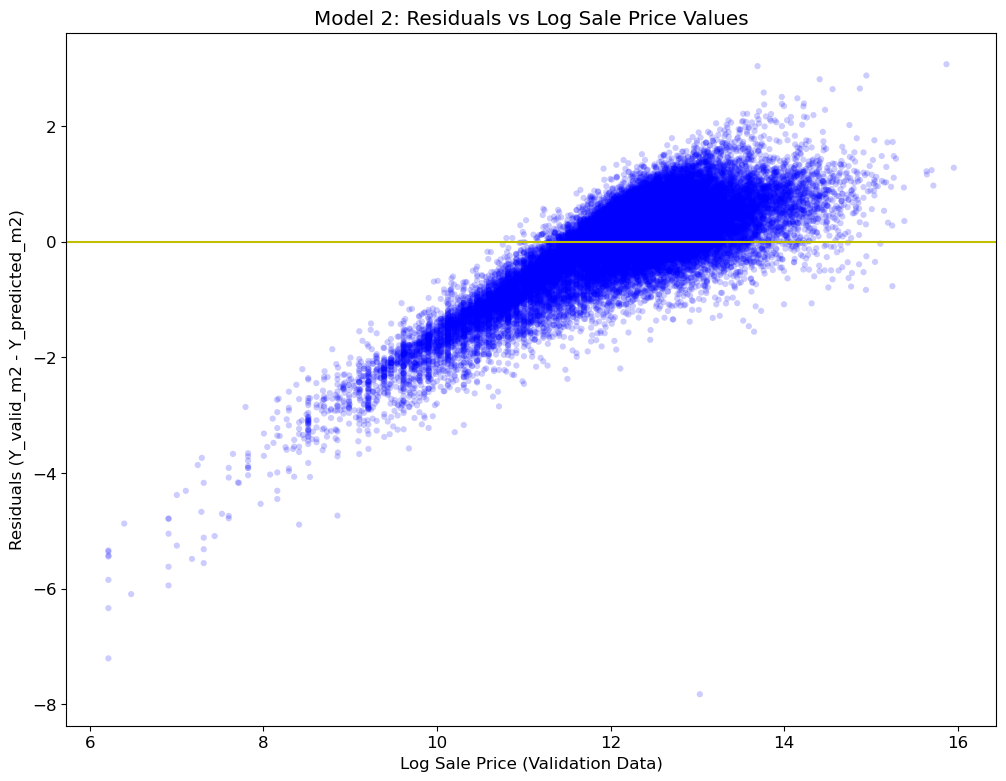

In [141]:
residuals_m2 = Y_valid_m2 - Y_predicted_m2
plt.scatter(Y_valid_m2, residuals_m2, alpha=0.2, s=20, c='b', edgecolors='none')
plt.axhline(color = 'y')
plt.xlabel('Log Sale Price (Validation Data)')
plt.ylabel('Residuals (Y_valid_m2 - Y_predicted_m2)')
plt.title('Model 2: Residuals vs Log Sale Price Values')



<!-- END QUESTION -->

<br>

--- 

## Question 4b

Based on the structure you see in your plot, does this model appear to correspond to _regressive_, _fair_, or _progressive_ taxation?

Assign "regressive", "fair" or "progressive" to `q4b` in the cell below accordingly.


In [142]:
q4b = 'regressive'

In [143]:
grader.check("q4b")

q4b results: All test cases passed!

<br>

--- 

## Question 4ci

`k`-fold cross validation (CV) allows us to more accurately evaluate our models than a single train-validation split. In `k`-fold CV, every data point is used in model training at some point. 

> Heads up: You should use `k`-fold cross validation to evaluate the different models you create in Question 5, as you will have limited submissions per day on Gradescope to assess your test RMSE. 

In this HW, we won't use `k`-fold CV to optimize for hyperparameters like we did in Lab 8, since OLS does not have any hyperparameters.

Instead, we will use `k`-fold cross validation to generate `k` estimates of the test set RMSE. These `k` RMSEs might be helpful when deciding between models in Question 5.   

Below, you will implement `compute_CV_error`. `compute_CV_error` should:
1. Use `sklearn`'s `KFold.split` ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html))  function to generate `k` splits of the training data. Note that `KFold.split` returns the indices of the data for each split.
2. For **each** split:
    1. Assign the folds to training and validation based on the split indices and desired features.
    2. Train the model on the training folds, and compute the RMSE on the validation fold.
3. Finally, return a **list** of the RMSEs computed for each validation fold. 
    
**Hint:**  This should be very similar to your implementation of `compute_CV_error` in Lab 8, but instead of returning an aggregated average of the folds, return the list of `k` RMSEs.
    
**Note:** The tests for this subpart only check the return value of `compute_CV_error` is a list of the correct length, 4cii will check for correctness.

In [144]:
from sklearn.model_selection import KFold

def compute_CV_error(X_train, Y_train, folds=10):
    '''
    Split the training data into `k` subsets.
    For each subset, 
        - Fit a model holding out that subset.
        - Compute the MSE on that subset (the validation set).
    You should be fitting `k` models in total.
    Return a list of `k` RMSEs.

    Args:
        model: An sklearn model with fit and predict functions. 
        X_train (DataFrame): Training data.
        Y_train (DataFrame): Label.
    
    Return:
         A list of `k` RMSEs.
    '''
    model = lm.LinearRegression(fit_intercept=True) # Use model that Question 5 requires.
    kf = KFold(n_splits=folds)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        predictions = model.predict(split_X_valid)
        error = rmse(predictions, split_Y_valid)
        
        validation_errors.append(error)

    return validation_errors

In [145]:
grader.check("q4ci")

q4ci results: All test cases passed!

<br>

--- 

## Question 4cii

Use `compute_CV_error` to generate two lists of RMSEs generated by 4-fold cross validation: one list for Model 1 and one list for Model 2. Assign these lists to `cv_m1` and `cv_m2`, respectively. 

To ensure the tests run as expected and the correct answers align with the tests, please do not change the random seed used in this question.

In [146]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)

# MODIFY THESE LINES
cv_m1 = compute_CV_error(X_train_m1, Y_train_m1, folds=4)
cv_m2 = compute_CV_error(X_train_m2, Y_train_m2, folds=4)
print(f"The RMSE errors for 4-fold cross-validation on Model 1 were: {cv_m1}")
print(f"The RMSE errors for 4-fold cross-validation on Model 2 were: {cv_m2}")

The RMSE errors for 4-fold cross-validation on Model 1 were: [0.8449406074214761, 0.8509652392813478, 0.839719896132506, 0.8390533114490786]
The RMSE errors for 4-fold cross-validation on Model 2 were: [0.7986296447828709, 0.8034792940524004, 0.7947882168346344, 0.7939635404119822]


In [147]:
grader.check("q4cii")

q4cii results: All test cases passed!

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement —— one reason is we have been only using 1 or 2 features (out of a total of 70+)! In the next part, you will engineer and incorporate more features to improve the model's fairness and accuracy.

<br>

<hr style="border: 1px solid #fdb515;" />

# 🏗️ Question 5

It is time to build your own model! Here's what's next:

1. You will conduct feature engineering on your training data using the `feature_engine_final` function (defined in `q5d`), and you will fit and evaluate the model with the training data.
2. You will process the test data with `feature_engine_final`, use the trained model to predict `Log Sale Price` for the test data, transform the predicted and original log-dollar values back to the dollar scale (by using `delog`), and compute the test RMSE.

Your goal in Question 5 is to:

* Define a function to perform feature engineering and produce a design matrix for modeling.
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses.
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that our test set does not contain the true `Sale Price` of each house –— your model can only predict them! 
* Submit your predicted `Log Sale Price`s on the test set to Gradescope.


Right under the grading scheme, we will outline some important Datahub logistics. **Please make sure you read this carefully to avoid running into memory issues later!**

* Question 5a (Not graded): You will explore possible features for your model.
* Question 5b (Not graded): You will perform EDA on the dataset. 
* Question 5c (Not graded): You can define feature engineering helper functions. 
* Question 5d (**Graded!**): You will create your design matrix and train a model. 
* Question 5e (Not graded): You will fit and evaluate your model. 
* Question 5f (**Graded!**): You will generate the predictions for the test set.

### Grading Scheme

Your grade for Question 5 will be based on your model's RMSE when making predictions on the training set, as well as your model’s RMSE when making predictions on the test set. The tables below provide scoring guidelines. If your RMSE lies in a particular range, you will receive the number of points associated with that range.

**Important**: While your training RMSE can be checked at any time in this notebook, your test RMSE can only be checked by submitting your model’s predictions to Gradescope. **You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. Attempts will not carry over across days, so we recommend planning ahead to make sure you have enough time to finetune your model! 

The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 200k | [200k, 240k) | [240k, 280k) | More than 280k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 240k | [240k, 280k) | [280k, 300k) | More than 300k

<br><br>

---
## Some notes before you start

- **If you are running into memory issues, restart the kernel and only run the cells you need to.** The cell below (question cell) contains most to all of the imports necessary to successfully complete this portion of the project. You do not need to rerun the cell at the top of this notebook to complete Question 5. The autograder will have more than 4GB of memory, so you will not lose credit as long as your solution to Question 5 is within the total memory (4GB) limits of Datahub. By default, we reset the memory and clear all variables using `%reset -f`. If you want to delete specific variables, you may also use `del` in place of `%reset -f%`. For example, the following code will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier.
- **If you need the data again after deleting the variables or resetting, you must reload them again from earlier in the notebook.**
- You will be predicting `Log Sale Price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e., if one of your `Log Sale Price` predictions is 60, it is too large; $e^{60}$ is too big!)
- You MUST remove any additional new cells you add before submitting to Gradescope to avoid any autograder errors. 
- **You can only submit your test set prediction CSV file to Gradescope up to 4 times per day. Start early!** In the case that you are approved for an extension, you will be granted 4 more submissions for each day the deadline has been extended.

**PLEASE READ THE ABOVE MESSAGE CAREFULLY!**

In [148]:
# The 3 lines below to clean up memory from previous questions and reinitialize Otter!
# If you want to refer to any functions or variables you defined at any point earlier in the project, 
# Place them in the cell under Question 5c so that you can access them after the memory is reset.
# If you think you will not run into any memory issues, you are free to comment out the next 3 lines as well.

%reset -f                               
import otter                            
grader = otter.Notebook("projA2.ipynb")

# Imports all the necessary libraries again

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br>

---

## Question 5a: Finding Potential Features

**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering in `q5d`. You may write as little or as much as you would like here; it will not factor into your grade. 

Read the documentation about the dataset in `codebook.txt`, located in this directory. Is there any data you think may be related to housing prices? You may want to take note of them below for future reference.

<br>

---

## Question 5b: More EDA


**This question is not graded** – it is intended to give helpful guidance on how to get started with feature engineering. You may write as little or as much as you would like here; it will not factor into your grade. 

Use the scratch space below to conduct any additional EDA you would like to see. You may use this space to make additional plots to help you visualize the relationship between variables or compute any relevant summary statistics. You are free to add any number of cells as needed below and before the next question. You may find it helpful to review Project A1 and the techniques we explore there.

Some potential ideas:
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers? This can inform how you engineer your features later on.

* Make a scatter plot between a continuous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

In [149]:
# Add any EDA code below

<br>

---

## Question 5c: Defining Helper Function or Helper Variables

**This question is not graded, but we suggest that you put all your helper functions below for readability and ease of testing.** Use this space below to define any additional helper functions you may use in your final model. These can be transformation functions you identified in the optional question above. 

In [150]:
# Define any additional helper functions or variables you need here

<br>

---

## Question 5d: Defining The Pipeline Function

**This question is graded.**

Akin to Question 4, you should encapsulate as much of your workflow into functions as possible. In the cell below, you should select better features and define your own feature engineering pipeline inside the function `feature_engine_final`. Use of `.pipe` is not required, but you are welcome to incorporate it! 

**You must not change the parameters inside `feature_engine_final`. Do not edit the two lines at the end of the question cell below. They are helper functions that define a linear model, fit your data, and compute RMSE. If you do, you will receive no credit for this question.** 

Additional requirements:
- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`, which is provided in the cell below.
- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`, provided in the cell below.
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `Y` (the `Log Sale Price` column).

**Hints:**
-  Some features may have missing values in the test set but not in the training/validation set. Make sure `feature_engine_final` handles missing values appropriately for each feature.
- We have imported all feature engineering functions from Project A1 for you. You do not have access to the `feature_func.py` file with the function body and definitions, but they work as defined in Project A1. Feel free to use them as you see fit!
- You may wish to consider removing outlying datapoints from the training set before fitting your model. You may not, however, remove any datapoints from the test set (after all, the CCAO could not simply "refuse" to make predictions for a particular house!)
- As you finetune your model, you may unintentionally consume too much Datahub memory, causing your kernel to crash. See `q5a` for guidance on how to resolve this!!

**Note:** If you run into any errors, the [Proj. A2 Common Mistakes](https://ds100.org/debugging-guide/projA2/projA2.html) section of the [Data 100 Debugging Guide](https://ds100.org/debugging-guide) may be a helpful resource.

In [151]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
def feature_engine_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        
        data = remove_outliers(data, 'Sale Price', np.percentile(data['Sale Price'],1),np.percentile(data['Sale Price'],99)) 
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data = add_total_bathrooms(data) 
        data[['Building Square Feet','Estimate (Building)','Land Square Feet']] = data[['Building Square Feet','Estimate (Building)','Land Square Feet']].fillna(0)
        data[['Building Square Feet','Estimate (Building)','Land Square Feet']] = data[['Building Square Feet','Estimate (Building)','Land Square Feet']].replace(0, 0.0001)
        data = remove_outliers(data, 'Estimate (Building)', np.percentile(data['Estimate (Building)'],0.25),np.percentile(data['Estimate (Building)'],99.75))
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        data = add_total_bathrooms(data)
        
        # Handle missing values for test set
        data[['Building Square Feet', 'Estimate (Building)', 'Land Square Feet', 'Fireplaces']] = data[['Building Square Feet', 'Estimate (Building)', 'Land Square Feet', 'Fireplaces']].fillna(0)
        data[['Building Square Feet', 'Land Square Feet']] = data[['Building Square Feet', 'Land Square Feet']].replace(0, 0.0001)
    
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    data['Log Land Size'] = np.log(data['Land Square Feet'])
    data['Bathrooms Squared'] = data['Bathrooms'] ** 2
    data['Age Squared'] = data['Age'] ** 2

    # Replacing with median for num values
    data['Log Estimate Building'] = np.log(data['Estimate (Building)'].replace(0, 0.0001))
    data['Rooms Per Area'] = data['Bathrooms'] / data['Building Square Feet'].replace(0, 1)  # Avoid division by zero
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Central Air'] = data['Central Air'].fillna(2).astype(int)  # 2 = no central air
    data['Repair Condition'] = data['Repair Condition'].fillna(2).astype(int)  # 2 = average
    data['Garage Indicator'] = data['Garage Indicator'].fillna(0).astype(int)  # 0 = no garage
    data['Latitude'] = data['Latitude'].fillna(data['Latitude'].median())
    data['Longitude'] = data['Longitude'].fillna(data['Longitude'].median())
    data['Neighborhood Code'] = data['Neighborhood Code'].fillna(data['Neighborhood Code'].median())
    
    features = [
        'Log Building Square Feet',    # Size
        'Log Land Size',              
        'Log Estimate Building',      
        'Bathrooms',                  
        'Bathrooms Squared',          # Non-linear
        'Rooms Per Area',            # Derived feature
        'Age',                   
        'Age Squared',               # Non-linear
        'Fireplaces',               
        'Central Air',             
        'Repair Condition',         # Condition
        'Garage Indicator',         # Amenities
        'Latitude',                 
        'Longitude',                
        'Neighborhood Code'         # Location
    ]
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        X = data[features]
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = data[features]
        # Response variable
        Y = data['Log Sale Price']
        
        return X, Y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), feature_engine_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("You can check your grade for your prediction as per the grading scheme outlined at the start of Question 5")

Current training RMSE: 137964.48294378002
You can check your grade for your prediction as per the grading scheme outlined at the start of Question 5


In [152]:
grader.check("q5d")

q5d results: All test cases passed!

<br>

---

## Question 5e: Fit and Evaluate your Model

**This question is not graded.** Use this space below to evaluate your models. Some ideas are listed below. 

**Note:** For grading purposes, you should use a `sklearn` default `LinearRegression()` model with intercept term. Do not modify any hyperparameter in `LinearRegression()`, and focus on feature selection or hyperparameters of your own feature engineering function.

It may also be helpful to calculate the RMSE directly as follows:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

A function that computes the RMSE is provided below. Feel free to use it if you would like calculate the RMSE for your training set.

In [153]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
Train set:

* Check your RMSE. Is this a reasonable number? You may use our grading scheme as a reference. Keep in mind that training error is generally less than testing error. 

Test set:
* Find the original data shape at the beginning of the notebook (in the provided assert statement). What should the output shape be?

* Since test and training/validation sets come from the same population (recall that test and training/validation sets are a random split from larger data), we expect our test prediction to have a similar range as the validation data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?

* We cannot compute test RMSE directly since we do not have the observed values. Perform cross-validation (feel free to use `compute_CV_error` from 4c) to estimate your test error. Recall that we are treating the validation set as unseen data.
    
</details>

In [100]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again


<br>

---

## Question 5f: Submission

**This question is graded.**

Recall that the test set provided to you in `cook_county_contest_test.csv` does not contain values for the true `Sale Price` of each house. You can only compute predictions of `Log Sale Price`. 

To determine your model's RMSE on the test set, you will submit the predictions made by your model to Gradescope. There, we will run checks to see what your test RMSE is by considering the (hidden) true values of `Sale Price` for the observations in the test set. 

- We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. So, be sure to submit predictions of the `Log Sale Price`. Before submitting to Gradescope, make sure that your predicted values can all be delogged/exponentiated (i.e., if one of your `Log Sale Price` predictions is 60, it is too large; $e^{60}$ is too big!)

Your score on this section will be determined by the grading scheme outlined at the start of Question 5. **Remember that you can only submit your test set predictions to Gradescope up to 4 times per day. Plan your time to ensure that you can adjust your model as necessary, and please test your model's performance using cross-validation before making any submissions.** 

- For more on cross-validation, check [Lecture 16](https://ds100.org/sp25/lecture/lec16/). In particular, the [Lecture 16 notebook](https://data100.datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FDS-100%2Fsp25-student&urlpath=lab%2Ftree%2Fsp25-student%2Flecture%2Flec16%2Flec16.ipynb&branch=main) may be helpful here. Feel free to use `compute_CV_error` from 4c as well! 

To determine the error on the test set, please submit your predictions on the test set to the Gradescope assignment **Project A2 Test Set Predictions**. The CSV file to submit is generated below, and you should not modify the cell below. Simply download the CSV file, and submit it to the appropriate Gradescope assignment.

**You will not receive credit for the test set predictions (i.e., up to 3 points) unless you submit to this assignment**!!

**Note:** If you run into any errors, the [Proj. A2 Common Mistakes](https://ds100.org/debugging-guide/projA2/projA2.html) section of the [Data 100 Debugging Guide](https://ds100.org/debugging-guide) may be a helpful resource.

In [65]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), feature_engine_final, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

#print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

You may now upload this CSV file to Gradescope for scoring.


In [66]:
# Scratch space to check if your prediction is reasonable. See 5e for hints. 
# We will not reset the submission count for mis-submission issues.
submission_df["Value"].describe()

count    55311.000000
mean        12.029169
std          1.700737
min         -5.588634
25%         11.567910
50%         12.122833
75%         12.646015
max         16.266744
Name: Value, dtype: float64

Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study, especially because statistical modeling is how the CCAO valuates properties. 

Refer to [Lecture 15](https://ds100.org/sp25/lecture/lec15/) if you're having trouble getting started!

<br>

<hr style="border: 1px solid #fdb515;" />

## 🫚 Question 6: Exploring RMSE

In this question, we will explore what RMSE means in the context of predicting house prices. We will go through different ways of visualizing the performance your model and see how it relates to questions about property taxes. 

In the cell below, we create the `preds_df` `DataFrame` for use in this question.

<br>

---

In [101]:
# Run the cell below; no further action is needed
train_df = pd.read_csv('cook_county_train.csv')
X, Y_true = feature_engine_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y_true)
Y_pred = model.predict(X)

In [102]:
preds_df = pd.DataFrame({'True Log Sale Price' : Y_true, 'Predicted Log Sale Price' : Y_pred, 
                         'True Sale Price' : np.e**Y_true, 'Predicted Sale Price' : np.e**Y_pred})
preds_df.head()

,True Log Sale Price,Predicted Log Sale Price,True Sale Price,Predicted Sale Price
1,12.560244,12.131774,285000.0,185678.910833
2,9.998798,11.030514,22000.0,61729.285531
3,12.323856,12.484310,225000.0,264160.061397
4,10.025705,10.285766,22600.0,29312.415362
6,11.512925,11.202391,100000.0,73305.534217


<br>

---
### Question 6a

Let's examine how our model performs on two halves of our data: `cheap_df`, which contains the rows of `preds_df` with prices below or equal to the median sale price, and `expensive_df`, which has rows of `preds_df` with true sale prices above the median. 

Take a moment to understand what is happening in the cell below, as it will also prove useful in `q6b`.  

In [103]:
# Run the cell below to obtain the two subsets of data; no further action is needed.
min_Y_true, max_Y_true = np.round(np.min(Y_true), 1) , np.round(np.max(Y_true), 1)
median_Y_true = np.round(np.median(Y_true), 1)
cheap_df = preds_df[(preds_df['True Log Sale Price'] >= min_Y_true) & (preds_df['True Log Sale Price'] <= median_Y_true)]
expensive_df = preds_df[(preds_df['True Log Sale Price'] > median_Y_true) & (preds_df['True Log Sale Price'] <= max_Y_true)]

print(f'\nThe lower interval contains houses with true sale price ${np.round(np.e**min_Y_true)} to ${np.round(np.e**median_Y_true)}')
print(f'The higher interval contains houses with true sale price ${np.round(np.e**median_Y_true)} to ${np.round(np.e**max_Y_true)}\n')


The lower interval contains houses with true sale price $2.0 to $219696.0
The higher interval contains houses with true sale price $219696.0 to $1468864.0



**Compute the RMSE of your model's predictions of `Sale Price` on `cheap_df` and `expensive_df` separately**. Assign these RMSE values to `rmse_cheap` and `rmse_expensive`, respectively.

Then, compute the proportion of houses in `cheap_df` and `expensive_df` for which the model overestimates `Sale Price`. Assign the proportions to `prop_overest_cheap` and `prop_overest_expensive`, respectively. 

- For example, if we were working with a dataset of 3 houses where the actual `Log Sale Price`s were [10, 11, 12] and the model predictions were [5, 15, 13], then the proportion of houses with overestimated values would be 2/3.

**Note:** When calculating `prop_overest_cheap` and `prop_overest_expensive`, you could use either `Log Sale Price` or `Sale Price`. Take a second to think through why this metric is unchanged under a log transformation.

In [110]:
rmse_cheap = rmse(cheap_df['Predicted Sale Price'], cheap_df['True Sale Price'])
rmse_expensive = rmse(expensive_df['Predicted Sale Price'], expensive_df['True Sale Price'])

prop_overest_cheap = np.mean(cheap_df['Predicted Sale Price'] > cheap_df['True Sale Price'])
prop_overest_expensive = np.mean(expensive_df['Predicted Sale Price'] > expensive_df['True Sale Price'])

print(f"The RMSE for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(rmse_cheap)}")
print(f"The RMSE for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(rmse_expensive)}\n")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(100 * prop_overest_cheap, 2)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(100 * prop_overest_expensive, 2)}%")

The RMSE for properties with log sale prices in the interval (0.7, 12.3) is 62603.0
The RMSE for properties with log sale prices in the interval (12.3, 14.2) is 187022.0

The percentage of overestimated values for properties with log sale prices in the interval (0.7, 12.3) is 55.78%
The percentage of overestimated values for properties with log sale prices in the interval (12.3, 14.2) is 31.9%


In [111]:
grader.check("q6a")

q6a results: All test cases passed!

<br>

---
### Question 6b

The intervals we defined above are broad. Let's try and take a more fine-grained approach to understand how RMSE and proportion of houses overestimated vary across different intervals of `Log Sale Price`. 

The functions `rmse_interval` and `prop_overest_interval` compute the RMSE and proportion of overestimated home prices for any interval of home prices, respectively. In the cell below, complete the implementation of these two function.

Pay close attention to the function descriptions, and feel free to reuse and modify the code you wrote in the previous part as needed.

**Note:** The autograder tests provided for each of the functions are **not** comprehensive as the outputs of the function are highly dependent on your model. Make sure that the values you obtain are interpretable and that the plots in 6c look appropriate.

In [114]:
def rmse_interval(df, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval [start, end].

    Input: 
    df : pandas DataFrame with columns 'True Log Sale Price', 
        'Predicted Log Sale Price', 'True Sale Price', 'Predicted Sale Price'
    start : A float specifying the start of the interval (inclusive)
    end : A float specifying the end of the interval (inclusive)
    '''

    subset_df = df[(df['True Log Sale Price'] >= start) & (df['True Log Sale Price'] <= end)]

    rmse_subset = rmse(subset_df['Predicted Sale Price'], subset_df['True Sale Price'])
    return rmse_subset
    
def prop_overest_interval(df, start, end):
    '''
    Given a DataFrame df, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval [start, end].

    Input: 
    df : pandas DataFrame with columns 'True Log Sale Price', 
        'Predicted Log Sale Price', 'True Sale Price', 'Predicted Sale Price'
    start : A float specifying the start of the interval (inclusive)
    end : A float specifying the end of the interval (inclusive)
    '''
    
    subset_df = df[(df['True Log Sale Price'] >= start) & (df['True Log Sale Price'] <= end)]

    # DO NOT MODIFY THESE TWO LINES
    if subset_df.shape[0] == 0:
        return -1

    prop_subset = np.mean(subset_df['Predicted Sale Price'] > subset_df['True Sale Price'])
    return prop_subset

In [115]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---
### Question 6c

Using the functions above, we can generate visualizations of how the RMSE and proportion of overestimated houses vary for different intervals:

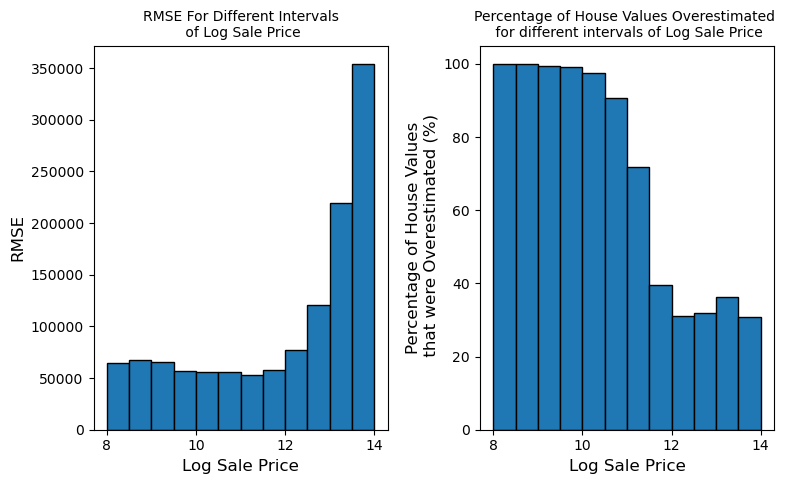

In [116]:
# RMSE plot
plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1) 
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(preds_df, i, i + 0.5))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE For Different Intervals\n of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('RMSE')

# Overestimation plot  
plt.subplot(1, 2, 2)
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(preds_df, i, i + 0.5) * 100) 
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated \n for different intervals of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('Percentage of House Values\n that were Overestimated (%)')

plt.tight_layout()
plt.show()

Which of the two plots above would be more useful in ascertaining whether the assessments tended to result in progressive or regressive taxation? Provide a brief explanation to support your choice of plot.

Then, explain whether your chosen plot aligns more closely aligns with scenario C or scenario D from `q1b`: 

    C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
    D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.

*Your response should be approximately X to Y sentences.*

The right plot would be more helpful and the right plot aligns with scenario C. It directly reveals the model’s bias in over- or underestimating property values across price ranges, which affects tax fairness. Despite that the left plot also shows that there's a bigger error as the sale price increases, however, it doens't tell us whether this error is over estimate or underestimate errors, whereas the plot on the right shows us that information, that the lower the sale price, the higher the percentage that it was overvalued, and vice versa. This plot on the right indicates that inexpensive properties are often overvalued (higher overestimation percentage), while expensive properties are less likely to be overvalued (lower overestimation percentage), aligning more closely with Scenario C, where inexpensive properties are overvalued and expensive ones undervalued, potentially leading to regressive taxation. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## 🕵️ Question 7: Evaluating the Model in Context

<br>

---
## Question 7a

When evaluating your model, we used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does a positive or negative residual affect them in terms of property taxes? Discuss the cases where the residual is positive and negative separately.

*Your response should be approximate 2 to 4 sentences.*

For an individual homeowner, the residual represents the difference between the true sale price of their house and the model’s predicted sale price, which is used as the assessed value for property taxes. A positive residual (true value higher than predicted) means the model underestimates the house’s value, leading to a lower tax bill, as the homeowner pays taxes on a value less than the true value, which would be a benefit to them since they're paying less tax than they should be. A negative residual (true value lower than predicted) means the model overestimates the house’s value, resulting in a higher tax bill, as the homeowner pays taxes on a value greater than the true value, which can be a financial disadvantage because now they pay more tax than they should be.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately —— that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness but also what fairness —— and justice —— means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL —— a suburb in Cook County —— as an example of housing equity beyond just improving a property valuation model: their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<!-- BEGIN QUESTION -->

<br>

---

## Question 7b

Reflecting back on your exploration in Questions 6 and 7a, in your own words, what makes a model's predictions of property values for tax assessment purposes "fair"? 

This question is open-ended and part of your answer may depend on your specific model; we are looking for thoughtfulness and engagement with the material, not correctness. 

**Hint:** Some guiding questions to reflect on as you answer the question above: What is the relationship between RMSE, accuracy, and fairness as you have defined it? Is a model with a low RMSE necessarily accurate? Is a model with a low RMSE necessarily "fair"? Is there any difference between your answers to the previous two questions? And if so, why?

*Your response should be approximate 1 to 2 paragraphs. Feel free to answer the questions in the hint to structure your answer.*

In the context of property tax assessments, a model’s predictions can be considered "fair" if they minimize systematic bias across different property value ranges, ensuring that no group of homeowners—whether they own inexpensive or expensive properties—is disproportionately over- or undervalued, which would lead to inequitable tax burdens, and also further highlight the discrepancies between income brackets. Fairness in this sense, means that the model’s errors (residuals) are not consistently skewed in a way that disadvantages certain groups, such as overvaluing inexpensive properties (leading to regressive taxation) or undervaluing expensive ones (leading to progressive taxation). Reflecting on Questions 6 and 7a, my model showed a tendency to overaluate inexpensive houses and less likely to overvalued expensive properties, as seen in the percentage of overestimated values plot. This suggests a lack of fairness because the low and mid-range properties are systematically overtaxed compared to others, creating an uneven tax burden that doesn’t align with true property values.

Considering the relationship between RMSE, accuracy, and fairness, a low RMSE indicates that the model’s predictions are, on average, close to the true values, which is a measure of accuracy. However, a low RMSE doesn’t guarantee fairness. For example, a model could have a low RMSE but still systematically overvalue inexpensive properties and undervalue expensive ones, as seen in the left plot of 'RSME vs log sale price', leading to regressive taxation that disproportionately burdens lower-income homeowners. In my model, the RMSE varied significantly across intervals, specifically peaking at log sale price > 12, suggesting larger errors for higher-priced homes, but the percentage overestimation plot revealed the direction of those errors, which is critical for fairness. A model with a low RMSE isn’t necessarily fair if its errors are biased in a way that creates inequitable tax outcomes, highlighting that fairness requires not just accuracy (low RMSE) but also an equitable distribution of errors across all property value ranges.

<!-- END QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Ayga and Beck congratulate you on finishing Project A2!

<center><video controls src = "aygabeck.mp4" width = "250">animation</video></a></center>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSdpKA_E3b7PGqKSRqBUgSebb9bVFhRwRBv1ueisGsnKFkZkYg/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project A2 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project A2 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. 

**Please make sure you submit the following to the right assignments:**

* **Project A2 Coding:** Submit the zip file generated by using the `grader.export()` cell provided below.
* **Project A2 Written:** Gradescope will automatically submit the PDF from the zip file submitted earlier. You do not need to submit anything to this assignment yourself, but *please check that the submission went through properly and that all plots rendered correctly*.
* **Project A2 Test Set Predictions:** Submit the CSV file generated in `q5f`.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

